In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util import sin_signal_freq,draw_latent_frequency

In [2]:
dataset, _ = sin_signal_freq()
np.random.shuffle(dataset)

In [ ]:
from datetime import datetime
from scipy.stats import norm
from scipy.signal import square
from sklearn.model_selection import train_test_split
import keras as kr

In [7]:
conf = {
    'seq_length': None,'feature_size': 2,
    'batch_size': 64,'latent_dim': 2,'epochs': 1,
    'optimizer': kr.optimizers.Adam(lr=0.001),
    # model architecture
    'dense_1': 64,'dense_2': 64,
    # sequence abstract feature representation
    'feature_rep_size': 100,
}
epsilon_std = 1.0
# input tensor placeholder
main_input = None

In [8]:
def roll(x):
    shifted = np.zeros_like(x)
    shifted[:, :-1, :] = x[0:, 1:, 0:]
    return shifted

In [9]:

def SequenceEncoder():
    """
    LSTM encoder with the last layer prediction as 
    the input to the dense layer which provides
    variational parameters `guassian mean` and 
    `guassian variance`
    """
    global main_input
    main_input = kr.layers.Input(shape=(None, conf['feature_size']))
    _lstm = kr.layers.LSTM(conf['feature_rep_size'], return_state=True)
    seq_1, st_h, st_c = _lstm(main_input)
    D1 = kr.layers.Dense(conf['latent_dim'])
    D2 = kr.layers.Dense(conf['latent_dim'])
    z_mean, z_log_var = (D1(st_h),D2(st_h))
    return z_mean, z_log_var, main_input
def SequenceDecoder(z, generator=False):
    """
    LSTM decoder conditioned on the output of the dense
    layer symetrical to the encoder
    """
    hidden_1 = kr.layers.Dense(conf['dense_1'], activation='elu')(z)
    state_1 = kr.layers.Dense(conf['feature_size'])(hidden_1)
    state_2 = kr.layers.Dense(conf['feature_size'])(hidden_1)
    lstm = kr.layers.LSTM(
        conf['feature_size'],
        return_sequences=True,
        activation='linear'
    )
    return lstm(main_input, [state_1, state_2])

In [10]:
def sampling(args):
    z_mean, z_log_var = args
    shp = kr.backend.shape(z_mean)[0]
    epsilon = kr.backend.random_normal(
        shape=(shp, conf['latent_dim']),
        mean=0.,
        stddev=epsilon_std
    )
    return z_mean + kr.backend.exp(z_log_var) * epsilon

In [12]:
# Custom loss layer
class VariationalLayer(kr.layers.Layer):
    """
    `Bottle Neck Layer`. This layer provides the
    kl-divergence loss function
    """
    def __init__(self, **kwargs):
        self.is_placeholder = True
        self.iter = 0
        # original time sequence shift once
        shp = (None, conf['feature_size'])
        self.target = kr.layers.Input(shape=shp)
        super(VariationalLayer, self).__init__(**kwargs)
    def vae_loss(self, x, x_decoded_mean):
        """
        kl-divergence loss plus reconstrucion loss 
        """
        mse = kr.metrics.mean_squared_error(self.target, x_decoded_mean)
        # sum error over time
        self.xent_loss = kr.backend.mean(mse, axis=1)
        kl_term = 1 + z_log_var - kr.backend.square(z_mean)
        kl_term-= kr.backend.exp(z_log_var)
        self.kl_loss = -0.5 * kr.backend.sum(kl_term, axis=-1)
        return kr.backend.mean(self.xent_loss + self.kl_loss)
    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [13]:
class Anealing(kr.callbacks.Callback):
    """
    scaling the kl-divergence loss by anealing it
    with a smooth function: tanh in this instance.
    the tanh in this case depends on the number 
    of epochs for the the rate of growth.
    """

    def tanh_aneal(self, itr):
        return (kr.backend.tanh((itr - 5.) / 0.25) + 1.) / 2.

    def on_batch_end(self, epoch, logs={}):
        iter_num = kr.backend.tf.cast(
            self.model.optimizer.iterations,
            kr.backend.tf.float32
        )
        aneal_factor = kr.backend.eval(
            self.tanh_aneal(iter_num)
        )
        self.model.get_layer("loss_layer").xent_loss *= aneal_factor
        return

In [14]:
z_mean, z_log_var, x = SequenceEncoder()
# note that "output_shape" isn't necessary with the TensorFlow backend
#z = Lambda(sampling, output_shape=(Config['latent_dim'],))([z_mean, z_log_var])
z = kr.layers.Lambda(sampling)([z_mean, z_log_var])
# we instantiate these layers separately so as to reuse them later
x_decoded_mean = SequenceDecoder(z)
# build model graph
vae_layer = VariationalLayer(name='loss_layer')
y = vae_layer([x, x_decoded_mean])
# compile VAE model
vae = kr.models.Model([x, vae_layer.target], y)
vae.compile(optimizer=conf['optimizer'], loss=None)


# build encoder and decoder graph nodes
encfunc = lambda args: args[0] + kr.backend.exp(args[1])
_encoder_layer = kr.layers.Lambda(encfunc,output_shape=(conf['latent_dim'],))
encoder_layer = _encoder_layer([z_mean, z_log_var])

encoder = kr.models.Model(x, encoder_layer)
decoder = kr.models.Model(x, x_decoded_mean)

In [16]:
print(vae.summary())
print(dataset.shape)
print("[ INFO ] Ready to train model")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 2)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 100), (None, 41200       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            202         lstm_1[0][1]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         lstm_1[0][1]                     
__________________________________________________________________________________________________
lambda_1 (

In [20]:
ds1 = roll(dataset)
H = vae.fit([dataset, ds1],shuffle=True,
        epochs=conf['epochs'],
        validation_split=0.1,
        batch_size=conf['batch_size'],
        callbacks=[Anealing()])

Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 18s 20ms/step - loss: 11.1188 - val_loss: 10.8340


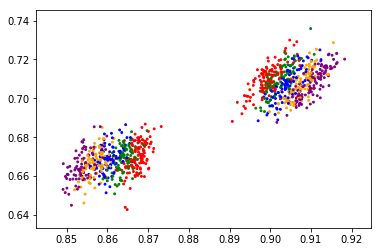

In [19]:
draw_latent_frequency(encoder)

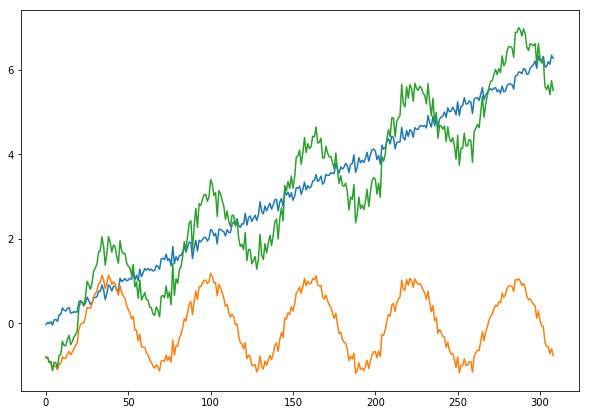

In [32]:
X = dataset[0][:,0]
Y = dataset[0][:,1]
f,a = plt.subplots(figsize=(10,7))
a.plot(X)
a.plot(Y)
a.plot(X+Y)
plt.show()

In [33]:
tosamp = X+Y
theta=[1,10]
def exp_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)
def conditional(x_new, x, y, params):
    B = exp_cov(x_new, x, params)
    C = exp_cov(x, x, params)
    A = exp_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

In [35]:
sig_0 = exp_cov(0, 0, theta)
xpts = np.arange(0, 300, step=0.01)
x = [1.]
y = [np.random.normal(scale=sig_0)]
y

[0.9653500312453794]

In [36]:
sig_1 = exp_cov(x, x, theta)